# Analyse Tokeniser 

In [11]:
model_dir = "./tests/temp/biobert"
bucket = "aegovan-data"
trainfile = "s3://{}/processed_dataset/train_multiclass.json".format(bucket)

column="normalised_abstract"


In [84]:
data_file="test_ensemble.json"


In [3]:
from pytorch_pretrained_bert import BertTokenizer


tokeniser = BertTokenizer.from_pretrained(model_dir, do_lower_case=False)

In [4]:
import boto3

def download_single_file(bucket_name_path, local_path):
    index = bucket_name_path.find("://")

    # remove the s3:// if present
    if index > -1:
        bucket_name_path = bucket_name_path[index + 3:]

    key_start_index = bucket_name_path.find("/")
    bucket_name = bucket_name_path
    key = "/"
    if key_start_index > -1:
        bucket_name = bucket_name_path[0:key_start_index]
        key = bucket_name_path[key_start_index + 1:]
        
    client = boto3.resource('s3')
    client.Bucket(bucket_name).download_file(key, local_path)



In [114]:
import json
import pandas as pd


def get_counts(input_file, column):
    data = pd.read_json(input_file)
            
    counts = []
    
    data["tokens"] =  data.apply (lambda x:  tokeniser.tokenize(x[column]), axis=1)
    data["token_len"] = data.apply (lambda x:  len(x["tokens"]), axis=1)
    return data

In [ ]:
download_single_file(trainfile, data_file) 

In [115]:
df = get_counts(data_file, column)

In [116]:
df.sample(n=10)

,actual,normalised_abstract,participant1Id,participant2Id,index,votes_acetylation,votes_demethylation,votes_dephosphorylation,votes_deubiquitination,votes_methylation,...,ubiquitination,ensemble_predicted_confidence,ensemble_predicted,ensemble_majority_prediction,ensemble_confidence_majority_prediction,particpant1Exists,particpant2Exists,particpantsExists,tokens,token_len
90,other,The Q96RI1 (Q96RI1) is a ligand (bile acid)-de...,Q96RI1,Q15466,90,0,0,0,0,0,...,2.414816,0.980938,other,other,3034.636708,True,True,True,"[The, Q, ##9, ##6, ##RI, ##1, (, Q, ##9, ##6, ...",506
298,other,"To complete cell division with high fidelity, ...",O43663,P38398,298,0,0,0,0,0,...,2.689539,0.998273,other,other,12362.863369,True,True,True,"[To, complete, cell, division, with, high, fi,...",367
99,other,The mammalian Q9Y6E0-like P97820 (P97820) and ...,P26038,O15121,99,0,0,0,0,0,...,2.692683,0.998321,other,other,12705.771742,True,True,True,"[The, ma, ##mmal, ##ian, Q, ##9, ##Y, ##6, ##E...",356
550,other,O00418 (O00418) phosphorylates and inactivates...,P13639,O00418,550,0,0,1,0,0,...,2.313522,0.956873,other,other,5475.439631,True,True,True,"[O, ##00, ##41, ##8, (, O, ##00, ##41, ##8, ),...",344
449,other,The polarization of eukaryotic cells is contro...,Q9NPB6,Q15831,449,0,0,0,0,0,...,2.447766,0.995746,other,other,10015.480830,True,True,True,"[The, polar, ##ization, of, e, ##uka, ##ryo, #...",456
798,methylation,The protein lysine methyltransferase Q8WTS6 re...,Q8WTS6,P26358,798,0,0,0,0,0,...,3.562178,0.996043,other,other,6534.387232,True,True,True,"[The, protein, l, ##ys, ##ine, met, ##hyl, ##t...",296
404,other,In examining the protein kinase components of ...,Q13164,P28482,404,0,0,0,0,0,...,2.595357,0.998271,other,other,12519.149524,True,True,True,"[In, examining, the, protein, kinase, componen...",431
69,other,Human P06729 is a 50-55-kDa cell surface recep...,P06241,P60568,69,0,0,0,0,0,...,1.984369,0.966497,other,other,2916.421670,True,True,True,"[Human, P, ##0, ##6, ##7, ##29, is, a, 50, -, ...",618
565,other,O00418 (O00418) phosphorylates and inactivates...,P42345,P28482,565,0,0,0,0,0,...,2.606124,0.998246,other,other,12250.565576,True,True,True,"[O, ##00, ##41, ##8, (, O, ##00, ##41, ##8, ),...",344
177,other,The Golgi apparatus has long been suggested to...,Q9Y6E0,O00506,177,0,0,0,0,0,...,2.799447,0.959405,other,other,6952.393147,True,True,True,"[The, Go, ##l, ##gi, apparatus, has, long, bee...",261


In [159]:
df["token_len"].describe(percentiles=[i/100 for i in range(0,100, 5)])

count    894.000000
mean     378.592841
std      110.356765
min      175.000000
0%       175.000000
5%       223.000000
10%      236.000000
15%      261.000000
20%      283.600000
25%      293.000000
30%      302.000000
35%      323.000000
40%      338.000000
45%      344.000000
50%      354.000000
55.0%    375.000000
60%      392.000000
65%      416.000000
70%      431.000000
75%      456.000000
80%      520.000000
85%      523.000000
90%      533.000000
95%      562.000000
max      618.000000
Name: token_len, dtype: float64

In [161]:
from sklearn.metrics import f1_score, accuracy_score,precision_score, recall_score

def get_scores(df, actual, predicted, labels=None):

    f1 = f1_score(df[actual], df[predicted], average='macro' ,sample_weight=None, labels=labels)  
    p = precision_score(df[actual], df[predicted], average='macro' ,sample_weight=None)  
    r = recall_score(df[actual], df[ predicted], average='macro' ,sample_weight=None)  

    return f1,p,r

def plot_confusion_matrix(df, actual, predicted):
    import matplotlib.pyplot as plt
    import scikitplot as skplt


    skplt.metrics.plot_confusion_matrix(df[actual], df[predicted], normalize=True , figsize=(4,4),  x_tick_rotation=90)
  

    skplt.metrics.plot_confusion_matrix(df[actual], df[predicted], figsize=(4,4), normalize=False,x_tick_rotation=90 )
    
    plt.show()


In [162]:
positive_labels = list(set(df["actual"].unique().tolist()) - set("other"))

In [129]:
df.shape

(894, 30)

In [155]:
get_scores ( df.query("token_len > 510"), "actual" , "ensemble_predicted")



(0.30709426627793973, 0.286231884057971, 0.3312368972746331)

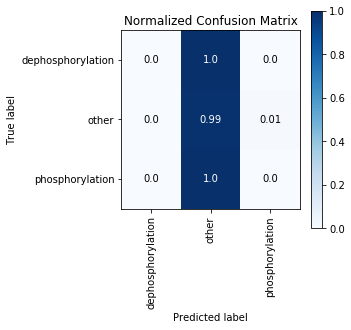

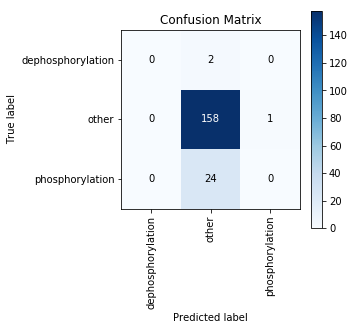

In [163]:
plot_confusion_matrix(df.query("token_len > 510"), "actual" , "ensemble_predicted")

In [147]:
get_scores ( df.query("token_len > 510"), "actual" , "ensemble_predicted", positive_labels)



/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(0.1151603498542274, 0.286231884057971, 0.3312368972746331)

In [138]:
df.query("token_len > 510").groupby( ["actual","ensemble_predicted" ])["actual","ensemble_predicted"].count()

actual  ensemble_predicted
actual            ensemble_predicted                            
dephosphorylation other                    2                   2
other             other                  158                 158
                  phosphorylation          1                   1
phosphorylation   other                   24                  24

In [126]:
get_scores ( df.query("token_len < 510"), "actual" , "ensemble_predicted")

(0.5523581281587611, 0.6653946176915744, 0.5284595695522575)

In [148]:
get_scores ( df.query("token_len < 510"), "actual" , "ensemble_predicted", positive_labels)

(0.5523581281587611, 0.6653946176915744, 0.5284595695522575)

In [151]:
get_scores ( df, "actual" , "ensemble_predicted")

(0.5399596900683856, 0.6636742637563926, 0.5139799154334038)